<a href="https://colab.research.google.com/github/hansbrunner/epidemiology-analysis/blob/main/cancer_prediction_age_smoking_sex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
import pandas as pd
import urllib.request

# Function to fetch and read XPT-files
def fetch_xpt_data(url, filename):
    urllib.request.urlretrieve(url, filename)  # Fetch XPT-file from URL
    data = pd.read_sas(filename)  # Read XPT-file to pandas DataFrame
    return data

# Get data
urls = {
    "demographics": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DEMO.XPT",  # Demographics
    "medical_conditions": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_MCQ.XPT",  # Medical conditions
    "smoking": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_SMQ.XPT" # Smoking questionnaire
}

demographics_data = my_functions.fetch_xpt_data(urls["demographics"], "demographics.xpt")
medical_conditions_data = my_functions.fetch_xpt_data(urls["medical_conditions"], "medical_conditions.xpt")
smoking_data = my_functions.fetch_xpt_data(urls["smoking"], "smoking.xpt")

# Select data from each dataset
demographics_relevant = demographics_data[['SEQN', 'RIAGENDR', 'RIDAGEYR']]  # Sex and age
medical_conditions_relevant = medical_conditions_data[['SEQN', 'MCQ220']]  # Lung cancer
smoking = smoking_data[['SEQN', 'SMQ020', 'SMQ040']]  # SMQ020 = Smoked more than 100 cigarettes, SMQ040 = Current smoker

# Merge datasets based on ID (SEQN)
df = pd.merge(demographics_relevant, medical_conditions_relevant, on='SEQN')
df = pd.merge(df, smoking, on='SEQN')

Mounted at /content/drive
       SEQN  RIAGENDR  RIDAGEYR  MCQ220  SMQ020  SMQ040
0  109264.0       2.0      13.0     NaN     NaN     NaN
1  109266.0       2.0      29.0     2.0     2.0     NaN
2  109267.0       2.0      21.0     2.0     2.0     NaN
3  109268.0       2.0      18.0     NaN     2.0     NaN
4  109271.0       1.0      49.0     2.0     1.0     1.0


In [64]:
"""
Relationship between smoking history and cancer
Nullhypothesis (H0): No relationship between smoking and cancer
Alternative hypothesis (H1): Smoking is associated with increased risk of developing cancer
"""
from scipy.stats import chi2_contingency
# remove incomplete data
filtered_data = df[
    df['MCQ220'].isin([1, 2]) & df['SMQ020'].isin([1, 2])
]
# Odds ratio
table = pd.crosstab(filtered_data['SMQ020'], filtered_data['MCQ220'], rownames=['Smoking'], colnames=['Cancer'])
a = table.iloc[0, 0]  # Smokers with cancer
b = table.iloc[1, 0]  # Non-smokers with cancer
c = table.iloc[0, 1]  # Smokers without cancer
d = table.iloc[1, 1]  # Non-smokers without cancer
odds_ratio = (a / c) / (b / d)
print(f'Odds Ratio: {odds_ratio}')

chi2, p, dof, expected = chi2_contingency(table)
print(f'Chi²: {chi2}, p-value: {p}')

Odds Ratio: 1.4409238951980052
Chi²: 29.620250191128388, p-value: 5.2553034220032655e-08
0.5359436078610481


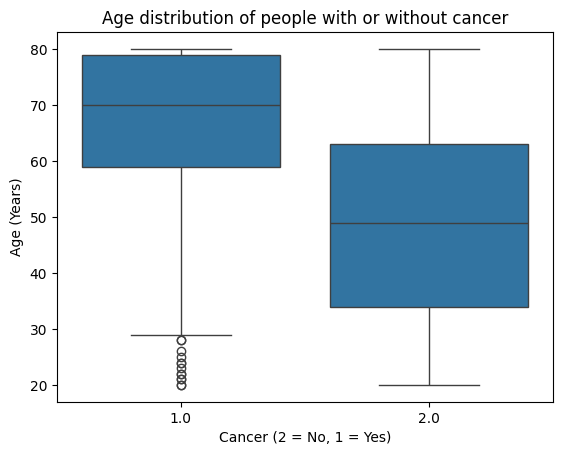

T-stat: 36.644011675351265, p-value: 3.827353824922563e-208


In [33]:
"""
Relationship between age and cancer
Nullhypothesis (H0): No relationship between age and cancer
Alternativ hypotese (H1): Elder people have increased risk of cancer
"""
from scipy.stats import ttest_ind
# remove incomplete data
filtered_data = df[df['MCQ220'].isin([1, 2])]

# visualize age distribution with box plots
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot of age and cancer status
sns.boxplot(x='MCQ220', y='RIDAGEYR', data=filtered_data)
plt.xlabel("Cancer (2 = No, 1 = Yes)")
plt.ylabel("Age (Years)")
plt.title("Age distribution of people with or without cancer")
plt.show()

# Average age for cancer and none cancer group
cancer_group = filtered_data[filtered_data['MCQ220'] == 1]['RIDAGEYR']
no_cancer_group = filtered_data[filtered_data['MCQ220'] == 2]['RIDAGEYR']

# T-test to see if there is a significant difference between age
t_stat, p_val = ttest_ind(cancer_group, no_cancer_group, equal_var=False)
print(f'T-stat: {t_stat}, p-value: {p_val}')

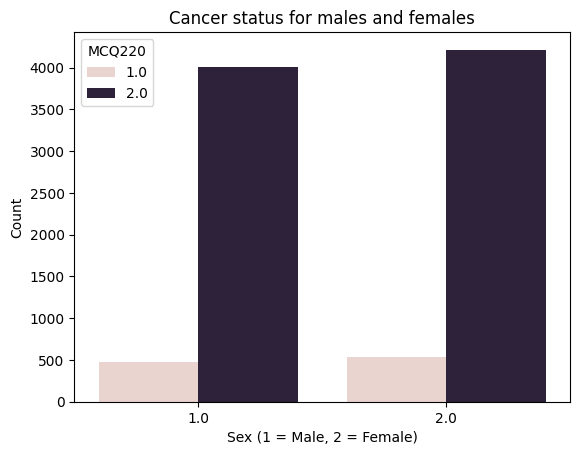

Odds Ratio: 0.921934116840945
Chi²: 1.3951805150335834, p-value: 0.23753217915574032


In [37]:
"""
Relationship between sex and cancer
Nullhypothesis (H0): No relationship between sex and cancer
Alternative hypothesis (H1): Relationship between sex and cancer
"""
# remove incomplete data
filtered_data = df[
    df['MCQ220'].isin([1, 2]) & df['RIAGENDR'].isin([1, 2])
]
# plot distribution of cancer between sexes
sns.countplot(x='RIAGENDR', hue='MCQ220', data=filtered_data)
plt.xlabel("Sex (1 = Male, 2 = Female)")
plt.ylabel("Count")
plt.title("Cancer status for males and females")
plt.show()

# Odds ratio
table = pd.crosstab(filtered_data['RIAGENDR'], filtered_data['MCQ220'], rownames=['Sex'], colnames=['Cancer'])
a = table.iloc[0, 0]  # Males with cancer
b = table.iloc[1, 0]  # Females with cancer
c = table.iloc[0, 1]  # Males without cancer
d = table.iloc[1, 1]  # Females without cancer

odds_ratio = (a / c) / (b / d)
print(f'Odds Ratio: {odds_ratio}')

chi2, p, dof, expected = chi2_contingency(table)
print(f'Chi²: {chi2}, p-value: {p}')

In [58]:
"""
Preprocess data for model
"""
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
# Clean data
cleaned_data = df.dropna(subset=['SMQ020', 'RIAGENDR', 'RIDAGEYR', 'MCQ220'])
filtered_data = cleaned_data.copy()
# 1 and 2 are legit answers to smoking history and cancer
filtered_data = filtered_data[
    (filtered_data['SMQ020'].isin([1, 2])) &
    (filtered_data['MCQ220'].isin([1, 2]))
]
# preprocess
filtered_data['Smoking'] = filtered_data['SMQ020'].apply(lambda x: 1 if x == 1 else 0) # 1 for yes, 0 for no
filtered_data['Female'] = filtered_data['RIAGENDR'].apply(lambda x: 1 if x == 2 else 0) # 1 for yes, 0 for no
filtered_data['Cancer'] = filtered_data['MCQ220'].apply(lambda x: 1 if x == 1 else 0) # 1 for yes, 0 for no

# normalize age
min_age = filtered_data['RIDAGEYR'].min()
max_age = filtered_data['RIDAGEYR'].max()
filtered_data['Normalized_Age'] = (filtered_data['RIDAGEYR'] - min_age) / (max_age - min_age)

X = filtered_data[['Smoking', 'Female', 'Normalized_Age']]
X = sm.add_constant(X) # add intercept
y = filtered_data['Cancer']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
ANOVA p-value: 0.0000
There are significant differences between the models.
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
     group1              group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
     Full Model              Null Model  -0.2434    0.0  -0.257 -0.2297   True
     Full Model            Shuffled Age  -0.2381    0.0 -0.2517 -0.2244   True
     Full Model         Shuffled Gender  -0.0116 0.1342 -0.0253   0.002  False
     Full Model Shuffled Smoking Status  -0.0039 0.9352 -0.0175  0.0098  False
     Null Model            Shuffled Age   0.0053 0.8197 -0.0083   0.019  False
     Null Model         Shuffled Gender   0.2318    0.0  0.2181  0.2454   True
     Null Model Shuffled Smoking Status   0.2395    0.0  0.2259  0.2532   True
   Shuffled Age         Shuffled Gender   0.2265    0.

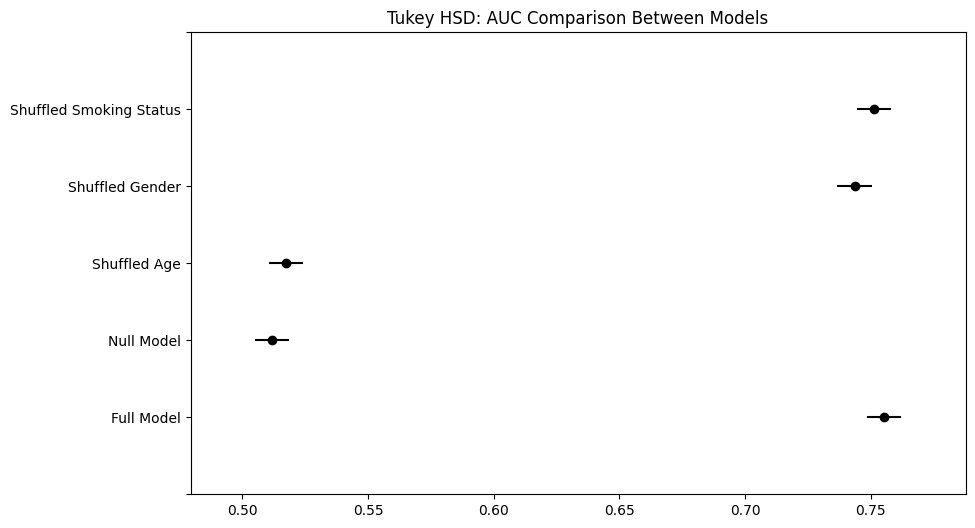

In [62]:
"""
Understanding Feature Importance and Model Performance Using Random Forest Classifier
In this analysis, I use a Random Forest classifier to predict cancer status.
First, I evaluate the performance of a full model using all features (age, smoking history, and sex). Then, I compare this to reduced models,
where I shuffle individual features (age, smoking history, and sex) to see how much the model's performance (measured by AUC) is affected.
Additionally, I include a null model, where the target variable (cancer) is shuffled to simulate random guessing.
By repeating this process multiple times, I use ANOVA to test whether the differences in AUC between models are statistically significant,
helping identifying the importance of each feature.
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Repeat the modeling process for a number of iterations
n_repeats = 30

# List to store results (AUC values and model types)
results = []

# Function to run models and return AUC
def run_models(X_train, X_test, y_train, y_test, model_name, shuffle_feature=None):
    X_train_copy = X_train.copy()

    # If shuffle_feature is not None, shuffle the specified feature
    if shuffle_feature:
        X_train_copy[shuffle_feature] = np.random.permutation(X_train_copy[shuffle_feature])

    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
    rf_model.fit(X_train_copy, y_train)

    # Calculate AUC on the test set
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    # Append the results to our list
    results.append({'model': model_name, 'AUC': auc})

# Repeat the modeling process for each model for n_repeats times
for _ in range(n_repeats):
    print(_)
    # Split the data into train and test sets for each iteration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None, stratify=y)

    # Full Random Forest model
    run_models(X_train, X_test, y_train, y_test, "Full Model")

    # Null model (shuffled y)
    y_train_shuffled = np.random.permutation(y_train)
    run_models(X_train, X_test, y_train_shuffled, y_test, "Null Model")

    # Shuffled Age
    run_models(X_train, X_test, y_train, y_test, "Shuffled Age", shuffle_feature='Normalized_Age')

    # Shuffled smoking status
    run_models(X_train, X_test, y_train, y_test, "Shuffled Smoking Status", shuffle_feature='Smoking')

    # Shuffled sex
    run_models(X_train, X_test, y_train, y_test, "Shuffled Gender", shuffle_feature='Female')

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Perform ANOVA test
anova_result = stats.f_oneway(
    results_df[results_df['model'] == 'Full Model']['AUC'],
    results_df[results_df['model'] == 'Null Model']['AUC'],
    results_df[results_df['model'] == 'Shuffled Age']['AUC'],
    results_df[results_df['model'] == 'Shuffled Smoking Status']['AUC'],
    results_df[results_df['model'] == 'Shuffled Gender']['AUC']
)

# Print the ANOVA results
print(f"ANOVA p-value: {anova_result.pvalue:.4f}")
if anova_result.pvalue < 0.05:
    print("There are significant differences between the models.")
else:
    print("There are no significant differences between the models.")

# Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=results_df['AUC'],      # AUC values
                          groups=results_df['model'],   # Model types (full, null, shuffled)
                          alpha=0.05)                   # Significance level

# Print the results
print(tukey)

# Plot the results for better visualization
tukey.plot_simultaneous()
plt.title('Tukey HSD: AUC Comparison Between Models')
plt.show()
